In [23]:
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state
from sklearn.metrics import silhouette_samples
from sklearn.utils.extmath import row_norms, stable_cumsum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from ucimlrepo import fetch_ucirepo

In [24]:
iris = fetch_ucirepo(id=53)

x = iris.data.features
y = iris.data.targets
iris_data_set = x.join(y)
iris_data = iris_data_set.loc[(iris_data_set['class'] == 'Iris-versicolor') | (iris_data_set['class'] == 'Iris-setosa')]
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

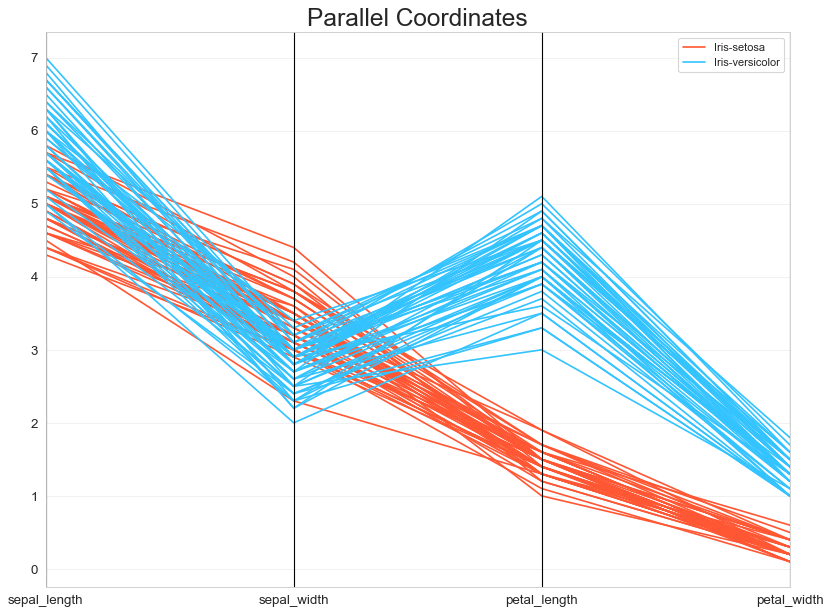

In [25]:
plt.figure(figsize=(12, 9), dpi=80)
parallel_coordinates(iris_data, 'class', color=['#FF5733', '#33C3FF'])  # Цвета для классов
plt.title('Parallel Coordinates', fontsize=22)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [26]:
iris_data_numeric= iris_data.drop(['class'], axis=1)

In [27]:
iris_data_numeric

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
95,5.7,3.0,4.2,1.2
96,5.7,2.9,4.2,1.3
97,6.2,2.9,4.3,1.3
98,5.1,2.5,3.0,1.1


## Кластерный анализ по методу k-средних

In [28]:
def init_centroids(X, n_clusters, random_state=None):
    random_state = check_random_state(random_state)
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    center_id = random_state.randint(n_samples)
    centers[0] = X[center_id]

    closest_dist_sq = row_norms(X - centers[0], squared=True)
    for c in range(1, n_clusters):
        probs = closest_dist_sq / closest_dist_sq.sum()
        cumulative_probs = stable_cumsum(probs)
        r = random_state.rand()
        next_center = np.searchsorted(cumulative_probs, r)
        centers[c] = X[next_center]
        closest_dist_sq = np.minimum(closest_dist_sq, row_norms(X - centers[c], squared=True))

    return centers

In [29]:
initial_centers = init_centroids(iris_data_numeric.values, n_clusters=2, random_state=42)
k = 2 
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
kmeans.fit(iris_data_numeric)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [30]:
final_centers = kmeans.cluster_centers_

In [31]:
labels = kmeans.labels_

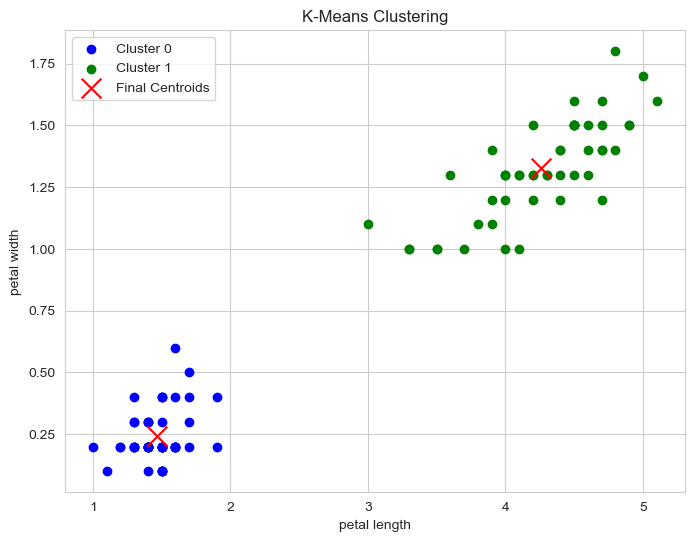

In [32]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i in range(k):
    cluster_points = iris_data_numeric[np.array(labels) == i]
    plt.scatter(cluster_points['petal_length'], cluster_points['petal_width'], c=colors[i], label=f'Cluster {i}')
plt.scatter(final_centers[:, 2], final_centers[:, 3], c='red', marker='x', s=200, label='Final Centroids')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend()
plt.title('K-Means Clustering')
plt.show()

In [33]:
cluster_counts = np.bincount(labels)
for i, count in enumerate(cluster_counts):
    print(f"Кластер {i}: {count} точек")

Кластер 0: 50 точек
Кластер 1: 50 точек


In [34]:
print(f"Количество итераций: {kmeans.n_iter_}")

Количество итераций: 2


In [35]:
centers_df = pd.DataFrame(
    {
        "Feature": ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"],
        "Initial Cluster 0": initial_centers[0],
        "Initial Cluster 1": initial_centers[1],
        "Final Cluster 0": final_centers[0],
        "Final Cluster 1": final_centers[1],
    }
)


print(centers_df.to_string(index=False))


     Feature  Initial Cluster 0  Initial Cluster 1  Final Cluster 0  Final Cluster 1
Sepal Length                6.4                5.8            5.006            5.936
 Sepal Width                3.2                2.7            3.418            2.770
Petal Length                4.5                4.1            1.464            4.260
 Petal Width                1.5                1.0            0.244            1.326


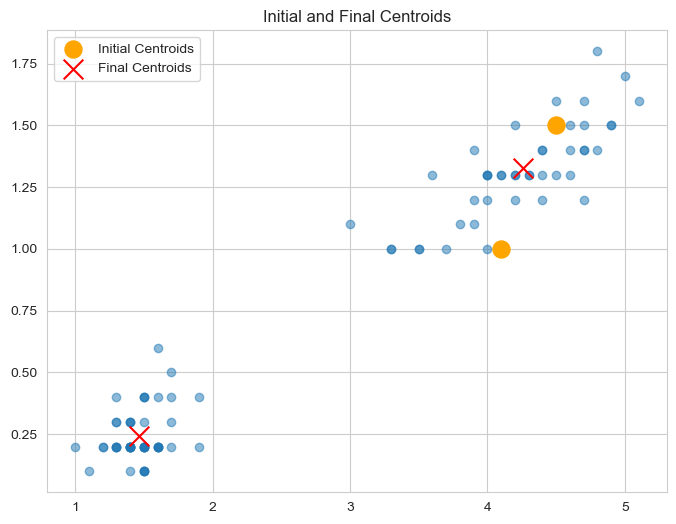

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(iris_data_numeric['petal_length'], iris_data_numeric['petal_width'], alpha=0.5)
plt.scatter(initial_centers[:, 2], initial_centers[:, 3], c='orange', marker='o', s=150, label='Initial Centroids')
plt.scatter(final_centers[:, 2], final_centers[:, 3], c='red', marker='x', s=200, label='Final Centroids')
plt.legend()
plt.title('Initial and Final Centroids')
plt.show()

In [37]:
sample_silhouette_values = silhouette_samples(iris_data_numeric, kmeans.labels_)

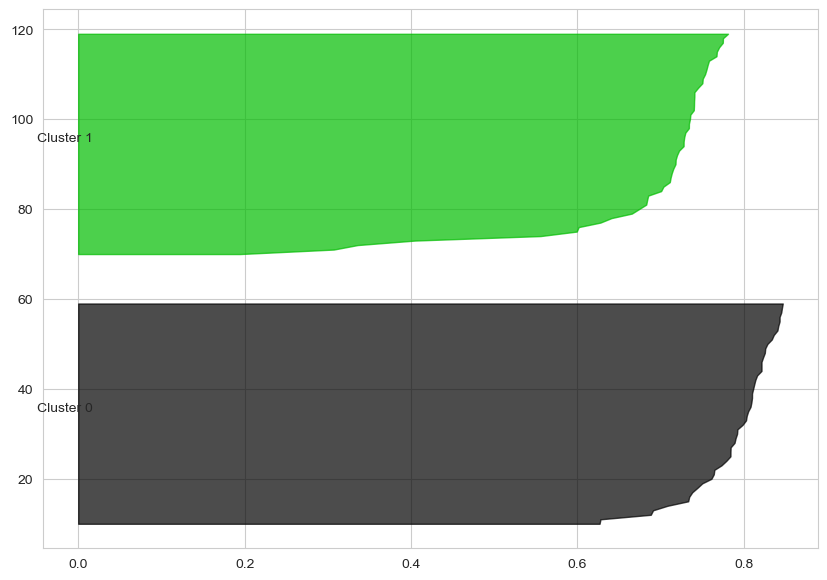

In [38]:
plt.figure(figsize=(10, 7))
y_lower = 10
for i in range(k):
    cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    cluster_silhouette_values.sort()

    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster, f"Cluster {i}")
    y_lower = y_upper + 10

## иерархический кластерный анализ

In [39]:
agglomerative_clustering = AgglomerativeClustering(linkage='ward')  
labels = agglomerative_clustering.fit_predict(iris_data_numeric)

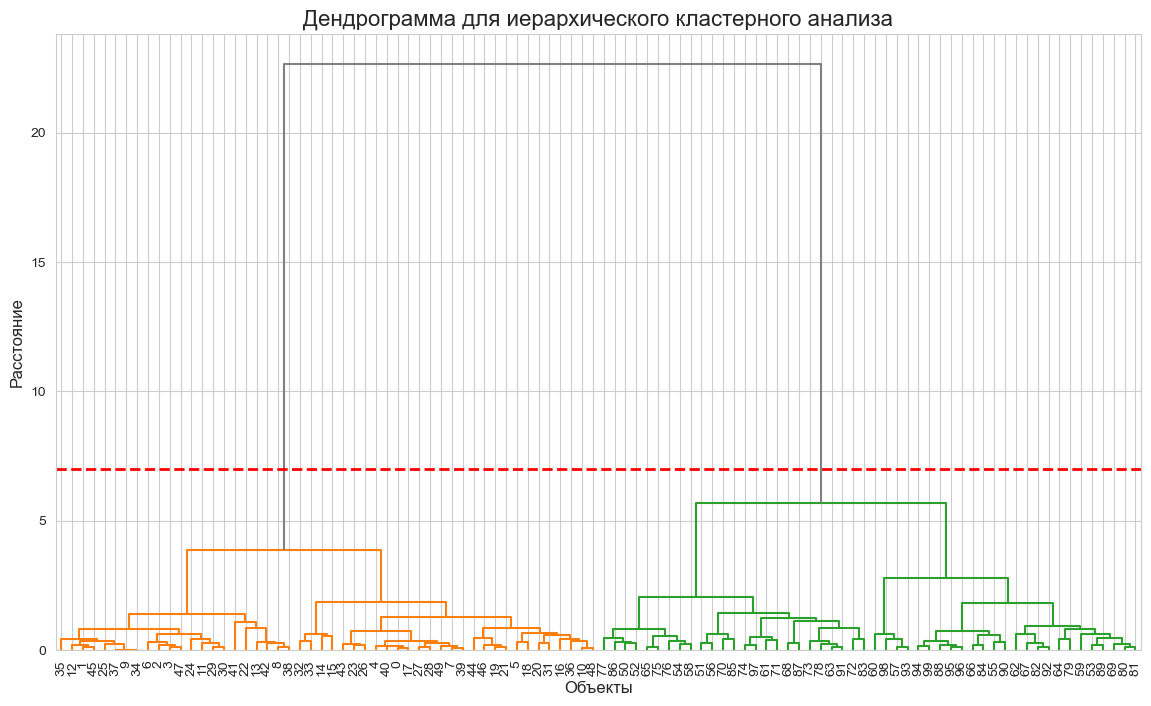

In [40]:
linkage_matrix = linkage(iris_data_numeric, method='ward')
plt.figure(figsize=(14, 8))  
dendrogram(
    linkage_matrix,
    leaf_rotation=90, 
    leaf_font_size=10,  
    color_threshold=7, 
    above_threshold_color='gray', 
    truncate_mode='level',  
    p=10
)


plt.title("Дендрограмма для иерархического кластерного анализа", fontsize=16)
plt.xlabel("Объекты", fontsize=12)
plt.ylabel("Расстояние", fontsize=12)


plt.axhline(y=7, c='red', linestyle='--', linewidth=2)  
plt.show()

In [ ]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Кластер {cluster}: {count} объектов")

Кластер 0: 50 объектов
Кластер 1: 50 объектов


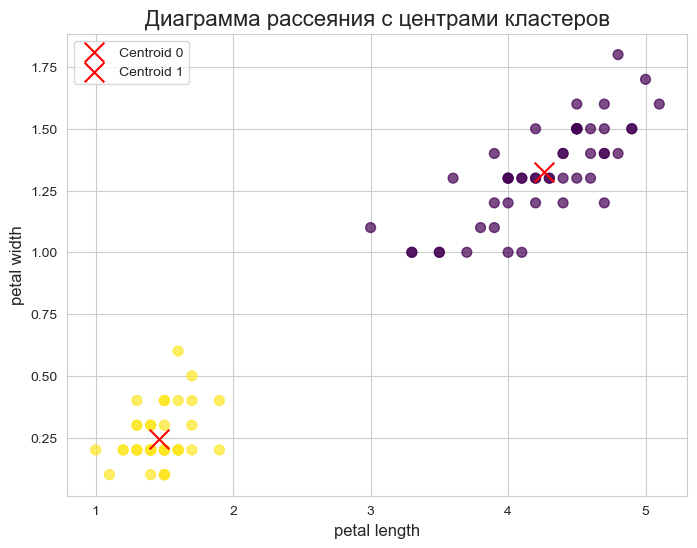

In [20]:
iris_data_numeric['Cluster'] = labels

cluster_centers = iris_data_numeric.groupby('Cluster').mean()

plt.figure(figsize=(8, 6))
plt.scatter(iris_data_numeric['petal_length'], iris_data_numeric['petal_width'], c=iris_data_numeric['Cluster'], cmap='viridis', s=50, alpha=0.7)

for i in range(k):
    plt.scatter(cluster_centers.loc[i, 'petal_length'], cluster_centers.loc[i, 'petal_width'], 
                color='red', s=200, marker='x', label=f'Centroid {i}')

plt.title('Диаграмма рассеяния с центрами кластеров', fontsize=16)
plt.xlabel('petal length', fontsize=12)
plt.ylabel('petal width', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

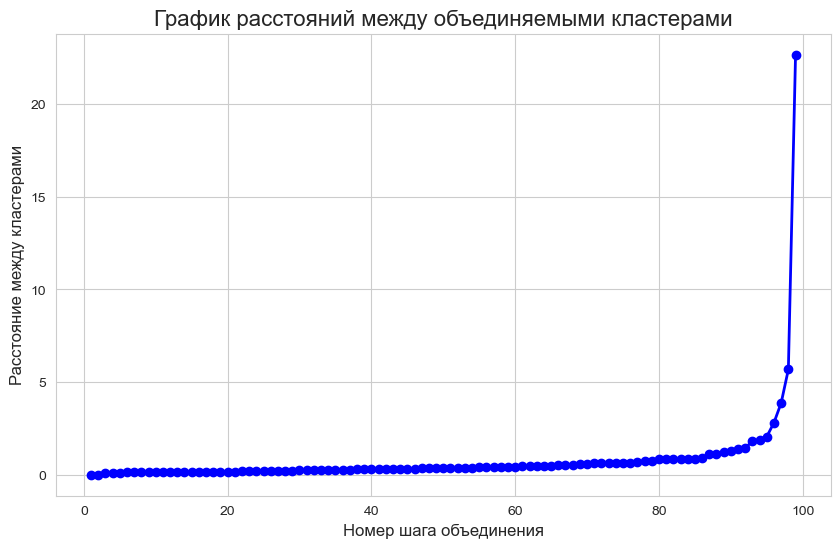

In [21]:
distances = linkage_matrix[:, 2]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(distances) + 1), distances, marker='o', color='b', linestyle='-', linewidth=2)

plt.title("График расстояний между объединяемыми кластерами", fontsize=16)
plt.xlabel("Номер шага объединения", fontsize=12)
plt.ylabel("Расстояние между кластерами", fontsize=12)
plt.grid(True)
plt.show()

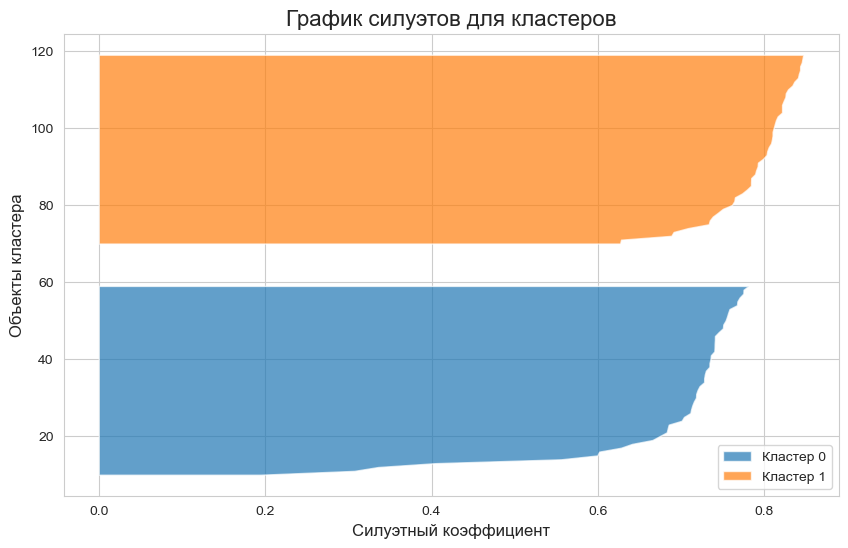

In [22]:
silhouette_values = silhouette_samples(iris_data_numeric.drop(columns=['Cluster']), labels)

plt.figure(figsize=(10, 6))
y_lower = 10 

for i in range(len(np.unique(labels))):
    cluster_silhouette_values = silhouette_values[labels == i]
    cluster_silhouette_values.sort()

    y_upper = y_lower + len(cluster_silhouette_values)

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        alpha=0.7,
        label=f"Кластер {i}"
    )
    y_lower = y_upper + 10  
plt.title("График силуэтов для кластеров", fontsize=16)
plt.xlabel("Силуэтный коэффициент", fontsize=12)
plt.ylabel("Объекты кластера", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()